In [2]:
import e2edro.DataLoad as dl
import e2edro.BaseModels as bm
import e2edro.e2edro as ilo
import e2edro.PortfolioClasses as bt
import e2edro.PlotFunctions as pf
import torch 
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## 1. Test if the machine is set up to run the code

In [3]:
print("CUDA available:", torch.cuda.is_available()) 
print("CUDA version:", torch.version.cuda)  
print("Torch version:", torch.__version__)
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA available: True
CUDA version: 12.6
Torch version: 2.6.0+cu126
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


## 2. Load the data

In [ ]:
# Import the data. The DataLoad AV() function now fetches data from yahoo finance
features_object, rets_object = dl.AV(start="2000-07-01", 
                                     end="2021-10-01", 
                                     split=[0.6, 0.4,0.0])

# Collect the number of feature
n_x = features_object.train().shape[1]

# Collect the number of assets
n_y = rets_object.train().shape[1]

# Collect the size of the sliding window
n_obs = features_object.n_obs

<h4>The Portfolio Constituent Assets and the Mean Returns Determining Factors </h4>
<img src="plots/data.png" alt="Loss Curve" width="500">

<h6>(From the  paper "Distriutionally Robust End-to-End Porfolio Constructions")</h6>



In [5]:
print("Training Set Features dimensions: ", features_object.train().shape)
print("Training Set Returns dimensions: ", rets_object.train().shape)

Training Set Features dimensions:  (665, 8)
Training Set Returns dimensions:  (665, 20)


## 3. Compute and Backtest the Basic Models

### 3.1. Run the backtest of the  equally weighted portfolio 

In [5]:
# Instantiate the equally-weighted benchmark model
ew = bm.equal_weight(n_x=n_x, n_y=n_y, n_obs=n_obs)

# Run the back test of the model
ew.net_roll_test(features_object, rets_object, n_roll=4)

### 3.2. Run the backtests of the predict-then-optimize (PO) portfolio construction models

In [6]:
seed = 42 

# Instantiate a mean optimizing predict-then-optimize model; The mean is estimated via linear regression.
po_m_lin = bm.pred_then_opt(n_x=n_x, 
                      n_y=n_y, 
                      n_obs=n_obs,                       
                      opt_layer='base_mod',
                      set_seed=seed)

# Instantiate a mean-variance predict-then-optimize model; The mean is estimated via linear regression.
po_mv_lin = bm.pred_then_opt(n_x=n_x, 
                      n_y=n_y, 
                      n_obs=n_obs, 
                      sigma=rets_object.train().cov(),  
                      kappa=1,
                      opt_layer='baseMV',
                      set_seed=seed)

po_m_lin.double()
po_mv_lin.double()

# Run the back test of the models
po_m_lin.net_roll_test(features_object, rets_object, n_roll=4)
po_mv_lin.net_roll_test(features_object, rets_object, n_roll=4)

Out-of-sample window: 1 / 4
Out-of-sample window: 2 / 4
Out-of-sample window: 3 / 4
Out-of-sample window: 4 / 4
Out-of-sample window: 1 / 4
Out-of-sample window: 2 / 4
Out-of-sample window: 3 / 4
Out-of-sample window: 4 / 4


### 3.3 Plot the portfolios equity curves

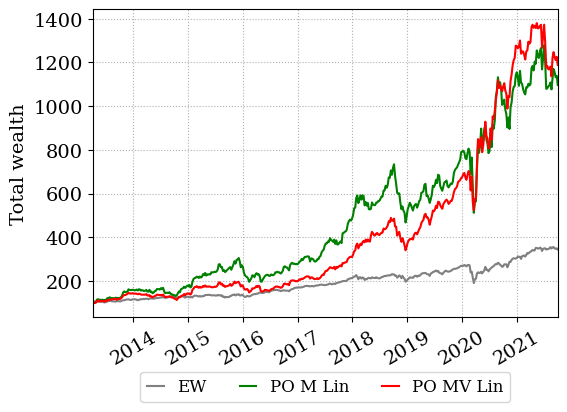

In [7]:
# Plot the backtest result
pf.wealth_plot([ew.portfolio, po_m_lin.portfolio,  po_mv_lin.portfolio], 
                ['EW', 'PO M Lin', 'PO MV Lin'], 
               ['grey',  'green', 'red']
              ) 

## 4. Run the backtests of the end-to-end portfolio construction models

In [ ]:
seed = 42 

# Set the params for the E2E-Linear Base model
pred_loss_factor = 0.35
epochs = 75
lr = 1e-4

# Instantiate the mean optimizing e2e model.
e2e_m_lin = ilo.e2e_net(n_x=n_x, 
                      n_y=n_y, 
                      n_obs=n_obs, 
                      opt_layer='base_mod', 
                      pred_model='linear', 
                      pred_loss_factor=pred_loss_factor,
                      epochs=epochs, lr=lr,
                      set_seed=seed)


 
# Set the params for the E2E-Linear Mean-Variance model
pred_loss_factor = 0.25
epochs = 100
lr = 1e-4

# Instantiate the mean-variance e2e model
e2e_mv_lin = ilo.e2e_net(n_x=n_x, 
                        n_y=n_y, 
                        n_obs=n_obs, 
                        sigma=rets_object.train().cov(), 
                        opt_layer='baseMV', 
                        pred_model='linear',
                        pred_loss_factor=pred_loss_factor,
                        epochs=epochs, lr=lr,
                        train_kappa=True,
                        set_seed=seed)

e2e_m_lin.double();
e2e_mv_lin.double();

In [16]:
# Run the backtests
folios =['e2e_m_lin', 'e2e_mv_lin']

for p in folios:
    eval(p).net_roll_test(features_object, rets_object, n_roll=4)

Out-of-sample window: 1 / 4
Out-of-sample window: 2 / 4
Out-of-sample window: 3 / 4
Out-of-sample window: 4 / 4
Out-of-sample window: 1 / 4
Out-of-sample window: 2 / 4
Out-of-sample window: 3 / 4
Out-of-sample window: 4 / 4


# 5. Display the results

### 5.1 Plot the equity curves of the mean optimizing portfolios

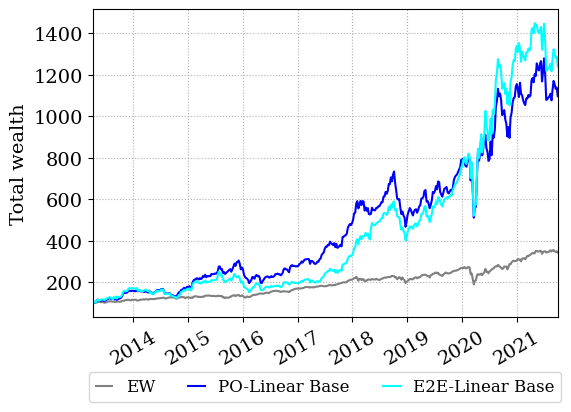

In [74]:
folios =['ew', 'po_m_lin', 'e2e_m_lin']

# Plot the wealth based on backtests
pf.wealth_plot([eval(p).portfolio for p in folios], 
               ['EW', 'PO-Linear Base', 'E2E-Linear Base'],
                ['grey', 'blue', 'cyan']) 

### 5.2 Plot the equity curves of the mean-variance portfolios

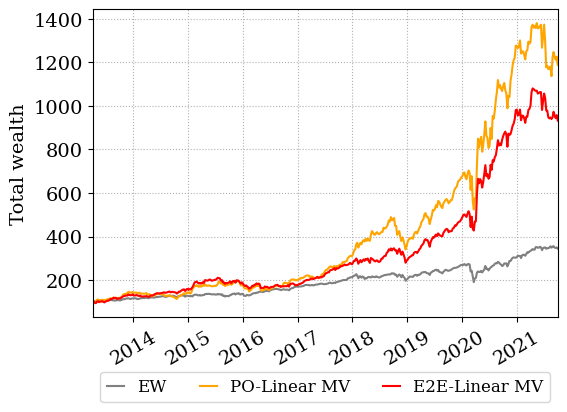

In [73]:
folios =['ew',  'po_mv_lin', 'e2e_mv_lin']

# Plot the wealth based on backtests
pf.wealth_plot([eval(p).portfolio for p in folios], 
               ['EW', 'PO-Linear MV', 'E2E-Linear MV'],
                 ['grey', 'orange', 'red']) 

### 5.3 Display porfolio stats for each System

In [69]:
folios =['ew', 'po_m_lin', 'e2e_m_lin', 'po_mv_lin', 'e2e_mv_lin']
folio_labels = ['EW', 'PO-Linear Base', 'E2E-Linear Base', 'PO-Linear MV', 'E2E-Linear MV']

# Display system evaluations
_dict = {p: [eval(p+'.portfolio').mean, 
             eval(p+'.portfolio').vol,
             eval(p+'.portfolio').sharpe,
             eval(p+'.portfolio').weights]
         for p in folios
        }

results = (pd.DataFrame(_dict, index=['Mean', 'Volatility', 'Sharpe Ratio', 'Weights'])
            .rename(columns = {folios[i] : folio_labels[i] for i in range(len(folios))})
             .transpose()
)

results.drop('Weights', axis=1)

,Mean,Volatility,Sharpe Ratio
EW,0.002795,0.020871,0.133936
PO-Linear Base,0.005421,0.043717,0.124008
E2E-Linear Base,0.005699,0.044148,0.129097
PO-Linear MV,0.005604,0.036364,0.154098
E2E-Linear MV,0.005052,0.030831,0.163873


### 5.4 Test for the diversification level of each system

In [50]:
# Plot the effective number of holdings for each system
effec_nbr_holdings = (pd.DataFrame([1/np.sum(results.Weights.loc[r]**2, axis=1) 
                                    for r in results.index[1:]
                                 ])               
                        .transpose()
                        .set_index(e2e_mv_lin.portfolio.dates)
                        .rename(columns={i: results.index[1:][i] for i in range(len(results.index[1:]))})
                   )

print('Effective Number of holdings: ')
effec_nbr_holdings.mean()

Effective Number of holdings: 


PO-Linear Base     1.000003
E2E-Linear Base    1.000001
PO-Linear MV       1.934695
E2E-Linear MV      2.213235
dtype: float64